# load packages

In [2]:
from pulp import *
import pandas as pd
import numpy as np
import os

# load data

In [3]:
pol_df = pd.read_csv('../data/pol_agg.csv')

In [4]:
pol_df = pol_df[pol_df['Source']!=pol_df['website']]

In [5]:
pol_df

,Source,website,page_url,TRUE,FALSE
1,www.facebook.com,www.politifact.com,22,0,22
2,nationalreport.net,www.whitehouse.gov,14,0,14
6,www.naturalnews.com,www.cdc.gov,8,0,8
7,www.facebook.com,www.snopes.com,8,1,7
9,www.infowars.com,www.cdc.gov,6,0,6
10,twitter.com,www.politifact.com,6,6,0
12,www.facebook.com,www.nytimes.com,6,0,6
13,dailycaller.com,apps.who.int,5,0,5
15,americannews.com,www.politifact.com,5,0,5
16,www.facebook.com,www.youtube.com,5,0,5


In [6]:
node_list = list(set(pol_df['Source']))

In [7]:
len(node_list)

166

In [8]:
pol_df.shape #check num of links

(1286, 5)

In [9]:
pol_df.columns

Index(['Source', 'website', 'page_url', 'TRUE', 'FALSE'], dtype='object')

# parse nodes / links information 

In [10]:
capacityNodes =  {}
capacityLink = {}
costTrueLink = {}
costFakeLink = {}
costTrueNode = {}
costFakeNode = {}

In [11]:
idxSource = 0
idxDestination = 1
idxTotal = 2
idxTrue = 3
idxFake = 4

In [12]:
nodes_map = {}

In [13]:
for i in range(pol_df.shape[0]):
    this_source = pol_df.iloc[i,idxSource]
    this_destinaiton = pol_df.iloc[i,idxDestination]
    this_total = pol_df.iloc[i,idxTotal]
    this_true = pol_df.iloc[i,idxTrue]
    this_fake = pol_df.iloc[i,idxFake]
    
    this_link_id = (this_source,this_destinaiton)
    
    if this_source in nodes_map:
        nodes_map[this_source].append(this_link_id)
    else:
        nodes_map[this_source] = [this_link_id]
    
    capacityLink[this_link_id] = this_total
    costTrueLink[this_link_id] = float(this_true)/float(this_total)
    costFakeLink[this_link_id] = float(this_fake)/float(this_total)
    
    if this_source in capacityNodes:
        capacityNodes[this_source] += this_total
        costTrueNode[this_source] += this_true
        costFakeNode[this_source] += this_fake
    else:
        capacityNodes[this_source] = this_total
        costTrueNode[this_source] = this_true
        costFakeNode[this_source] = this_fake

In [14]:
for x in node_list:
    costTrueNode[x] = float(costTrueNode[x]) / float(capacityNodes[x])
    costFakeNode[x] = float(costFakeNode[x]) / float(capacityNodes[x])

# set up symbolic model: link based

In [18]:
link_list = list(set(capacityLink.keys()))

In [48]:
def linkbasedNetworkOpt(lambda_Fake,maxNewsControl):
    #problem
    probLink = LpProblem('LinkBased_NewsNetwork',LpMaximize)
    
    #variables
    linkProbLink = LpVariable.dicts('link',link_list,0)
    nodeProbLink = LpVariable.dicts('node',node_list,0)
    nodeControl = LpVariable.dicts('nodecontrol_binary',node_list,0,1,LpInteger)
    controlProbLink = LpVariable('news control',0)
    
    #objective
    probLink += (lambda_Fake*lpSum([ linkProbLink[x]*costFakeLink[x] for x in link_list ]) - lpSum([ linkProbLink[x]*costTrueLink[x] for x in link_list]) ) #+ lambdaNewsControl*controlProbLink
    
    #link constraints
    for x in link_list:
        probLink += linkProbLink[x]<=capacityLink[x]
        
    #node constraints
    for x in node_list:
        probLink += nodeProbLink[x]<=capacityNodes[x]*nodeControl[x]
        
    #sum link = nodes flow
    for x in node_list:
        probLink += lpSum([ linkProbLink[y] for y in nodes_map[x]]) == nodeProbLink[x]
        
    #calculate news control
    probLink += lpSum([ nodeControl[x] for x in node_list]) == controlProbLink
    probLink += controlProbLink <= maxNewsControl
    
    probLink.solve()
    
    return linkProbLink,nodeProbLink,controlProbLink,probLink

# set up symbolic model: node based

In [49]:
def nodebasedNetworkOpt(lambda_Fake,maxNewsControl):
    #problem
    probLink = LpProblem('LinkBased_NewsNetwork',LpMaximize)
    
    #variables
    nodeProbLink = LpVariable.dicts('node',node_list,0)
    nodeControl = LpVariable.dicts('nodecontrol_binary',node_list,0,1,LpInteger)
    controlProbLink = LpVariable('news control',0)
    
    #objective
    probLink += (lpSum([ lambda_Fake*nodeProbLink[x]*costFakeNode[x] for x in node_list ]) -lpSum([ nodeProbLink[x]*costTrueNode[x] for x in node_list]) ) #+ lambdaNewsControl*controlProbLink
        
    #node constraints
    for x in node_list:
        probLink += nodeProbLink[x]<=capacityNodes[x]*nodeControl[x]
        
    #calculate news control
    probLink += lpSum([ nodeControl[x] for x in node_list]) == controlProbLink
    probLink += controlProbLink <= maxNewsControl
    
    probLink.solve()
    
    return nodeProbLink,controlProbLink,probLink

# run optimization and print the result

In [21]:
#total news flow
pol_df['page_url'].sum()

1597

In [22]:
pol_df['TRUE'].sum()

111

In [23]:
pol_df['FALSE'].sum()

1486

### link based first, no penalty on true news

In [99]:
lambdaFake=0
maxNewsControl=16 #about 10% of the total news flow

In [100]:
vLink,vNode,vControl,probLink = linkbasedNetworkOpt(lambdaFake,maxNewsControl) #linkProbLink,nodeProbLink,controlProbLink,probLink

In [101]:
vControl.varValue

0.0

In [102]:
def censorshipCalculation_linkbased(vL,true_total = pol_df['TRUE'].sum(),fake_total=pol_df['FALSE'].sum()):
    true_news_left = 0
    fake_news_left = 0
    for x in vL:
        thispath_flow = vL[x].varValue
        true_news_left += (capacityLink[x]-thispath_flow)*costTrueLink[x]
        fake_news_left += (capacityLink[x]-thispath_flow)*costFakeLink[x]
    return true_news_left/true_total,fake_news_left/fake_total

In [103]:
censorshipCalculation_linkbased(vLink)

(1.0, 1.0)

### link based, set a small penalty on true news

In [104]:
lambdaFake=1
maxNewsControl=16 #about 10% of the total news flow
vLink,vNode,vControl,probLink = linkbasedNetworkOpt(lambdaFake,maxNewsControl) #linkProbLink,nodeProbLink,controlProbLink,probLink

In [105]:
vControl.varValue

16.0

In [106]:
censorshipCalculation_linkbased(vLink)

(0.98198198198198194, 0.59825033647375503)

### link based, penalty adjusted to balance the amount of fake/true news

In [113]:
lambdaFake=15
maxNewsControl=16 #about 10% of the total news flow
vLink,vNode,vControl,probLink = linkbasedNetworkOpt(lambdaFake,maxNewsControl) #linkProbLink,nodeProbLink,controlProbLink,probLink

In [114]:
vControl.varValue

16.0

In [115]:
censorshipCalculation_linkbased(vLink)

(0.94594594594594594, 0.59555854643337824)

### link based, plot

In [150]:
trueList = []
fakeList = []
for i in np.arange(0,100,0.2):
    lambdaFake=i
    maxNewsControl=16 #about 10% of the total news flow
    vLink,vNode,vControl,probLink = linkbasedNetworkOpt(lambdaFake,maxNewsControl) #linkProbLink,nodeProbLink,controlProbLink,probLink
    thisTrue,thisFake = censorshipCalculation_linkbased(vLink)
    trueList.append(thisTrue)
    fakeList.append(thisFake)

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

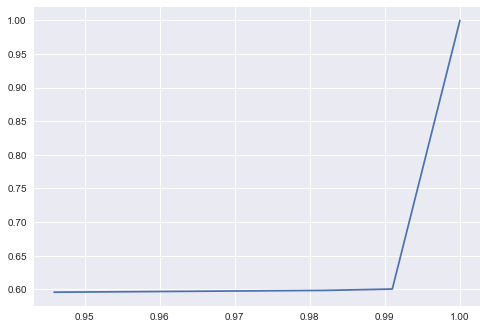

In [153]:
sns.set_style("darkgrid")
plt.plot(trueList,fakeList)
plt.show()

### node based

In [157]:
def censorshipCalculation_nodebased(vN,true_total = pol_df['TRUE'].sum(),fake_total=pol_df['FALSE'].sum()):
    true_news_left = 0
    fake_news_left = 0
    for x in vN:
        thisnode_flow = vN[x].varValue
        true_news_left += (capacityNodes[x]-thisnode_flow)*costTrueNode[x]
        fake_news_left += (capacityNodes[x]-thisnode_flow)*costFakeNode[x]
    return true_news_left/true_total,fake_news_left/fake_total

In [144]:
lambdaFake=15
maxNewsControl=16 #about 10% of the total news flow
vNode,vControl,probLink = nodebasedNetworkOpt(lambdaFake,maxNewsControl) #linkProbLink,nodeProbLink,controlProbLink,probLink

In [145]:
censorshipCalculation_nodebased(vNode)

(0.54054054054054057, 0.59555854643337824)

### compare link based and node based

In [155]:
trueList_nodebased = []
fakeList_nodebased = []
for i in np.arange(0,5,0.1):
    lambdaFake=i
    maxNewsControl=16 #about 10% of the total news flow
    vNode,vControl,probLink = nodebasedNetworkOpt(lambdaFake,maxNewsControl) #linkProbLink,nodeProbLink,controlProbLink,probLink
    thisTrue,thisFake = censorshipCalculation_nodebased(vNode)
    trueList_nodebased.append(thisTrue)
    fakeList_nodebased.append(thisFake)

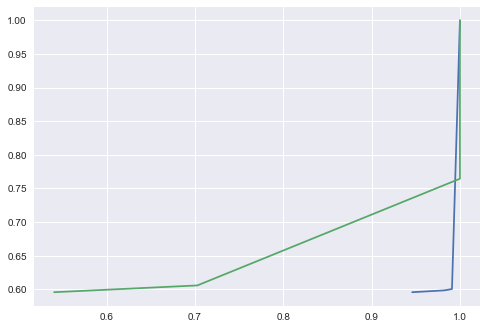

In [156]:
sns.set_style("darkgrid")
plt.plot(trueList,fakeList,trueList_nodebased,fakeList_nodebased)

plt.show()

# compare optimization result with network structures

In [160]:
lambdaFake=5
maxNewsControl=16 #about 10% of the total news flow
vNode,vControl,probLink = nodebasedNetworkOpt(lambdaFake,maxNewsControl) #linkProbLink,nodeProbLink,controlProbLink,probLink

In [161]:
censorshipCalculation_nodebased(vNode)

(0.54054054054054057, 0.59555854643337824)

In [162]:
network_df = pd.read_csv('../data/ClassificationModelInput.csv')

In [163]:
network_df.columns

Index(['Source', 'Destination', 'page_url', 'TRUE.', 'FALSE.',
       'Source_Real_LocalDegreeCentralities',
       'Destination_Real_LocalDegreeCentralities',
       'Source_Real_LocalBetweenness', 'Destination_Real_LocalBetweenness',
       'Source_Real_LocalCloseness', 'Destination_Real_LocalCloseness',
       'Source_Real_LocalEigenCentralities',
       'Destination_Real_LocalEigenCentralities',
       'Source_Fake_LocalDegreeCentralities',
       'Destination_Fake_LocalDegreeCentralities',
       'Source_Fake_LocalBetweenness', 'Destination_Fake_LocalBetweenness',
       'Source_Fake_LocalCloseness', 'Destination_Fake_LocalCloseness',
       'Source_Fake_LocalEigenCentralities',
       'Destination_Fake_LocalEigenCentralities', 'jaccard_coeff_connection',
       'Neighbor_connection', 'jaccard_coeff_common_destination',
       'Neighbor_common_destination', 'jaccard_coeff_common_source',
       'Neighbor_common_source', 'mutuality_ind'],
      dtype='object')

In [165]:
network_df = network_df[['Source','Source_Real_LocalDegreeCentralities','Source_Real_LocalBetweenness','Source_Real_LocalCloseness','Source_Real_LocalEigenCentralities','Source_Fake_LocalDegreeCentralities','Source_Fake_LocalBetweenness','Source_Fake_LocalCloseness','Source_Fake_LocalEigenCentralities']]

In [166]:
network_df

,Source,Source_Real_LocalDegreeCentralities,Source_Real_LocalBetweenness,Source_Real_LocalCloseness,Source_Real_LocalEigenCentralities,Source_Fake_LocalDegreeCentralities,Source_Fake_LocalBetweenness,Source_Fake_LocalCloseness,Source_Fake_LocalEigenCentralities
0,www.facebook.com,143.333333,0.007485,0.044768,143.333333,1.0,0.000000,0.028924,1.0
1,nationalreport.net,NaN,NaN,NaN,NaN,1.0,0.000000,0.028315,1.0
2,www.naturalnews.com,NaN,NaN,NaN,NaN,1.0,0.000000,0.029356,1.0
3,www.facebook.com,143.333333,0.007485,0.044768,143.333333,1.0,0.000000,0.028924,1.0
4,www.infowars.com,4.666667,0.000000,0.033905,4.666667,1.0,0.000000,0.001171,1.0
5,twitter.com,4.666667,0.000000,0.031257,4.666667,1.0,0.000000,0.030045,1.0
6,www.facebook.com,143.333333,0.007485,0.044768,143.333333,1.0,0.000000,0.028924,1.0
7,dailycaller.com,NaN,NaN,NaN,NaN,1.0,0.000000,0.028738,1.0
8,americannews.com,4.666667,0.000000,0.033747,4.666667,7.0,0.000022,0.029840,7.0
9,www.facebook.com,143.333333,0.007485,0.044768,143.333333,1.0,0.000000,0.028924,1.0


# generate optimized network and plot it